# Determining the Optimal Number of Topics or Clusters

If building a supervised model with SciKit Learn, `GridSearchCV` is an essential tool for tuning the best hyperparameters for a model. `GridSearchCV` works by essentially fitting a model for each of the combinations of hyperparameters and providing a cross-validated score for each combination of features. At the end of the process, it is able to determine which values of hyperparameters result in the best score. 

Because I am using unsupervised learning techniques (KMeansClustering in SciKit Learn and Latent Dirichlet Allocation in Gensim) in this project, I am unable to use `GridSearchCV` to determine the optimal number of topics/clusters for my data. To overcome this, I have built functions to allow me to assess a metric score and explore topic key words for each number of clusters/topics. 

With unsupervised learning techniques, such as clustering, often the number of clusters that results in the best score might not be the most interpretable. Therefore, it will be important to make sure that any clusters or topics that emerge from the model also have clear meaning to the human that is evaluating them. **Here, I will appy these functions to the General Women's Health and Fertility and Pregancy data to try and find clusters/topics that are not only optimized for a scoring metric but also interpretable.**

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spacy
import spacy

# Scipy
import scipy.sparse

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Gensim
from gensim import matutils
from gensim import corpora
# from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# NLTK
from nltk.corpus import stopwords

# Silence Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Color Palette

In [2]:
blush = '#F7D1CD'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

## Read-In Data

In [3]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health Shape: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn Shape: {obsgyn.shape}')

Health Shape: (30616, 7)
ObsGyn Shape: (92943, 7)


## Define Stop Words

Prior to creating a document term matrix from the text data, I will read in stop words from spaCy and NLTK. These stop words will be combined with custom stop words to create a full list of stop words.

In [4]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [5]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'subreddit']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

## Create Document Term Matrix (DTM) From Corpus

In order to convert each document (post) in the corpus to a vector, I will use ***Sklearn***'s `TfidfVectorizer`. TF-IDF stands for Term Frequency-Inverse Document Frequency. Essentially, using this vectorizer, words that appear frequently in a document but also appear frequently in several documents throughout the corpus are not weighted as heavily as words that appear frequenly in a document but infrequently in the corpus. For an overview of TF-IDF, check out this [video](https://www.youtube.com/watch?v=4vT4fzjkGCQ). 

#### Function to Convert Text to a DTM

In [6]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create DTM for Each Health Domain

In [7]:
# Vectorizer, dtm are outputed from build_tvec

health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')


#### Transform DTM into a Term Document Matrix (TDM) That is Compatible with Gensim

Gensim requires the format of the input to be a Gensim corpus data type. In order to convert the document-term matrix to a corpus, we must first convert it to a term-document matrix, which is the tranpose of the document-term matrix. Once the term-document matrix is created, it is converted to a compressed sparse row matrix, and finally a Gensim corpus.

**Note**: Code for these steps was modified from [A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial) by Alice Zhao

***FOR GENSIM MODELS ONLY!*** 

In [8]:
def create_tdm(dtm):
    tdm = dtm.transpose() # transpose dtm
    return tdm

def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

#### Transform the DTM to TDM for Each Health Domain

In [9]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)

## Define the Vocabulary That Was Used in the Vectorizer

Gensim also requires that a dictionary, containing the vocabulary and index of the term, be input into the model. This can be done using a dictionary comprehension or using the `.from_corpus` method. 

***For Gensim Models***

In [10]:
def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [11]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)

***For SciKit Learn Models***

In [12]:
health_terms = health_vectorizer.get_feature_names()
obsgyn_terms = obsgyn_vectorizer.get_feature_names()

## Grid Search

In the following code, I will use custom functions to determine the optimal number of clusters/topics for each model and data set. These functions have been designed to return a list of scoring metrics and a dictionary of fitted models. The list of scoring metrics can be plotted to see how the metrics vary across different numbers of clusters/topics, and having access to the fitted model allows me to find the most important terms for each cluster/topic.

### K-Means Clustering
#### Functions

In [13]:
def grid_search_kmeans(start, stop, step, dtm):
    
    silhouettes = []
    models = {}
    
    for i in range(start, stop, step):
        
        # Build KMeans Model
        kmeans = KMeans(n_clusters = i, random_state = 42, n_jobs = -1)
        kmeans.fit(dtm)
        models[i] = kmeans
        
        # Calculate Silhouette Score & Append to List
        preds = kmeans.fit_predict(dtm)
        sil_score = silhouette_score(dtm, preds)
        silhouettes.append(sil_score)
        
    return models, silhouettes

In [14]:
def plot_gs_results(start, stop, step, list_of_scores, title = None, x_label = None, y_label = None):
    plt.figure(figsize = (12, 8))
    sns.lineplot(x = range(start, stop, step), y = list_of_scores, linewidth = 2, color = '#B392AC')
    plt.title(title, fontdict = {'fontsize': 15}, pad = 8)
    plt.xlabel(x_label, fontdict = {'fontsize': 12}, labelpad = 8)
    plt.ylabel(y_label, fontdict = {'fontsize': 12}, labelpad = 8)
    plt.tight_layout();

In [15]:
def get_topic_terms_kmeans(model, k, terms, n_terms = 15):
# Code modified from # https://pythonprogramminglanguage.com/kmeans-text-clustering/

    sorted_centroids = model.cluster_centers_.argsort()[:, ::-1]
    
    topic_dictionary = {}
    for i in range(k):
        topics_list = []
        for index in sorted_centroids[i, :n_terms]:
                topics_list.append(terms[index])
        topic_dictionary[i] = topics_list
    
    return topic_dictionary

#### KMeans Grid Search for General Women's Health Data

Below I will use the K-Means grid search function to build 12 models, ranging from 2 to 24 in steps of 2. Each model will be evaluated on silhouette score. The silhouette score is provides a measure of how similar points in a cluster are to each other and how separated a cluster is from other clusters. A silhouette score can range from -1 (Bad) to 1 (Excellent).

In [16]:
# Save dictionary of models and list of silhouette scores
health_kmeans_models, health_silhouettes = grid_search_kmeans(2, 25, 2, health_dtm)

Once the models have been built, the silhouette scores can be plotted for each of the numbers of clusters.

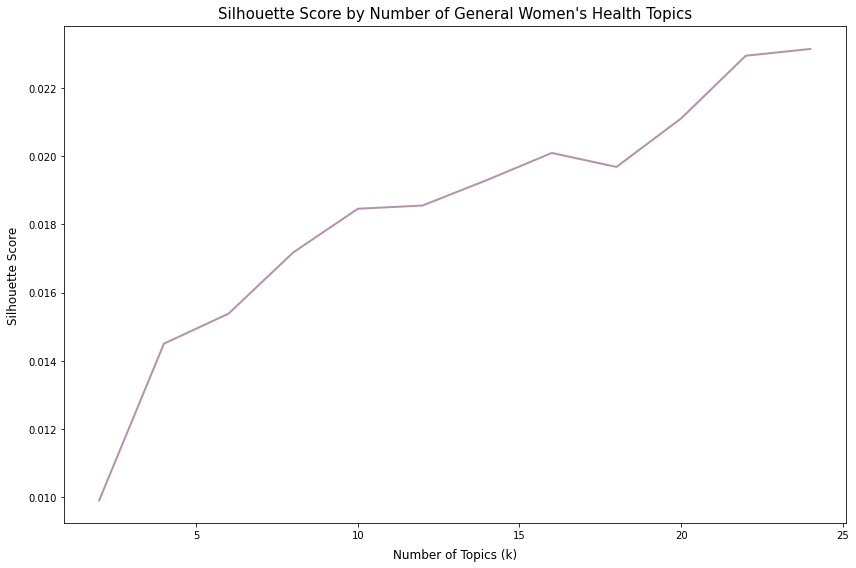

In [17]:
plot_gs_results(2, 25, 2, 
                health_silhouettes, 
                title = 'Silhouette Score by Number of General Women\'s Health Topics',
                x_label = 'Number of Topics (k)',
                y_label = 'Silhouette Score')

In the above plot, we are able to see that as the number of clusters (k) increases, the silhouette score also increases. However, even though the metric might look better for more clusters, the clusters might not be interpretable or make sense to a human observer. Therefore, in order to determine which number of clusters is best for the data, the top terms for each cluster needs to be evaluated.

In general, the silhouette scores for these models are low and indicate poor separation between clusters. A value of clusters ~17 seems to provide a "peak" silhouette score. Because the grid search function built models with values of K that increment by 2, I can look at the cluster terms for 16 clusters using the following code:

In [18]:
# To prevent excessive output, only the first cluster is shown.

health_kmeans_16 = health_kmeans_models[16]

get_topic_terms_kmeans(health_kmeans_16, 1, health_terms, 10) # To view all clusters, change 1 to 16

{0: ['discharge',
  'brown',
  'brown discharge',
  'period',
  'white',
  'normal',
  'smell',
  'notice',
  'vaginal',
  'infection']}

Upon inspecting the resulting clusters, for the most part 16 clusters seems to provide fairly interpretable clusters and would be a good starting point for building the actual models. It is important to note that this is a starting point, and the number of clusters used in the actual model might differ.

#### KMeans Grid Search for Fertility and Pregnancy Data

The same process can be repeated for the Fertility and Pregnancy data.

In [ ]:
obsgyn_kmeans_models, obsgyn_silhouettes = grid_search_kmeans(2, 25, 2, obsgyn_dtm)

In [ ]:
plot_gs_results(2, 25, 2, 
                obsgyn_silhouettes, 
                title = 'Silhouette Score by Number of Fertility and Pregnancy Topics',
                x_label = 'Number of Topics (k)',
                y_label = 'Silhouette Score')

In general, the silhouette scores for these models are also low and indicate poor separation between clusters. A value of ~16  clusters seems to provide a balance between higher silhouette score and number of topics. I can examine the cluster terms for this model.

In [ ]:
# To prevent excessive output, only the first cluster is shown.

obsgyn_kmeans_16 = obsgyn_kmeans_models[16]

get_topic_terms_kmeans(obsgyn_kmeans_16, 1, obsgyn_terms, 10) # To view all clusters, change 1 to 16

Overall, the 16 clusters identified here seem fine. This will be a good starting point.

### Latent Dirichlet Allocation (LDA)

Below I will use the LDA grid search function to build 10 models, ranging from 2 to 21 topics in steps of 2. Each model will be evaluated on UMass cohesion score. The cohesion score measures how similar the words in a topic are to one another. For the UMass score, the closer a score is to 0, the more similar the words in the topic are.

#### Functions

In [ ]:
def build_gensim_lda(corpus, n_topics, vocabulary, n_passes):
    lda = LdaModel(corpus = corpus, num_topics = n_topics, id2word = vocabulary, passes = n_passes, decay = 0.7, offset = 10, random_state = 2020)
    return lda

In [ ]:
def build_gensim_coherence_model(model, corpus, dictionary):
    coherence = CoherenceModel(model=model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
    return round(coherence.get_coherence(), 3)

In [ ]:
# Grid Search Function Modified from Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def grid_search_lda(corpus, vocabulary, n_passes, start, stop, step_size):
    
    models_dict = {}
    coherence_list = []
    
    for i in range(start, stop, step_size):
        lda_model = build_gensim_lda(corpus, i, vocabulary, n_passes)
        models_dict[i] = lda_model # Save model to dictionary with # topics as key
        coherence = build_gensim_coherence_model(lda_model, corpus, vocabulary)
        coherence_list.append(coherence)
         
    return models_dict, coherence_list

In [ ]:
def plot_coherence_by_topic(start, stop, step_size, coherence_list, size = (12, 8), title = None, x_label = None, y_label = None):
    plt.figure(figsize = size)
    sns.lineplot(x = range(start, stop, step_size), y = coherence_list, linewidth = 2, color = dark_purple)
    plt.xlabel(x_label, fontdict = {'fontsize':12}, labelpad = 8)
    plt.ylabel(y_label, fontdict = {'fontsize':12}, labelpad = 8)
    plt.title(title, fontdict = {'fontsize':15}, pad = 8)
    plt.xticks(range(2,21,2), size = 11)
    plt.yticks(size = 11)
    plt.tight_layout();

In [ ]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

#### Grid Search for Women's Health Data

In [ ]:
health_lda_models, health_lda_coherence = grid_search_lda(corpus = health_corpus, 
                                                          vocabulary = health_vocabulary, 
                                                          n_passes = 10, 
                                                          start = 2, 
                                                          stop = 21, 
                                                          step_size = 2);

The above code results in a dictionary of fitted models and a list of coherence scores. By plotting the coherence scores for the range of topic numbers, I am able to assess how cohesion changes with the number of topics.

In [ ]:
plot_coherence_by_topic(2, 21, 2, 
                        health_lda_coherence, 
                        size = (12, 8), 
                        title = 'Coherence Score by Number of Women\'s Health Topics', 
                        x_label = 'Number of Topics', 
                        y_label = 'UMass Coherence Score')

From the following plot, we are able to see that cohesion can vary greatly by number of topics. The ideal numbers of topics appear to possibly be 4 or 10. The terms for these topics can be viewed with the folloing code:

```python
health_lda_model_4 = health_lda_models[4]
get_topic_terms(health_lda_model_4, 4, 4)

health_lda_model_10 = health_lda_models[10]
get_topic_terms(health_lda_model_10, 10, 10)
```

After exploring the topic terms, however, the topics did not seem as informative as I had hoped. Although the cohesion score for 12 topics is worse, this number of topics seemed to provide more insight into possible health concerns. The topics and terms after 10 iterations of LDA are shown below.

In [ ]:
health_lda_model_12 = health_lda_models[12]
get_topic_terms(health_lda_model_12, 12, 10)

Overall, 12 topics seems to result in fairly clear and interpretable topics and will be a good place to start for building the main LDA model. It is important to note that the LDA in the main notebook will run for 50 iterations, so topics might vary slightly from this notebook.

#### Grid Search for Fertility and Pregnancy Data

The same process can be followed for the fertility and pregnancy data.

In [ ]:
obsgyn_lda_models, obsgyn_lda_coherence = grid_search_lda(corpus = obsgyn_corpus, 
                                                          vocabulary = obsgyn_vocabulary, 
                                                          n_passes = 10, 
                                                          start = 2, 
                                                          stop = 21, 
                                                          step_size = 2);

In [ ]:
plot_coherence_by_topic(2, 21, 2, 
                        obsgyn_lda_coherence, 
                        size = (12, 8), 
                        title = 'Coherence Score by Number of Fertility and Pregnancy Topics', 
                        x_label = 'Number of Topics', 
                        y_label = 'UMass Coherence Score')

From this plot, 4 and 10 seem to be optimal number of topics. Because 4 topics will likely not provide enough fine-grained detail, I will begin by exploring the top terms for 10 topics.

In [ ]:
obsgyn_lda_model_10 = obsgyn_lda_models[10]
get_topic_terms(obsgyn_lda_model_10, 10, 10)

At a glance, these 10 topics appear to be interpretable and informative. Building the LDA model (50 iterations) with 10 topics should be a great starting point.

## Final Thoughts

Although these grid search functions are computationally expensive (they're building 10-12 separate models each!), they are very helpful in providing a quick assessment of a scoring metric and basic topic description. 